## Lab 7.01 Neural Network Binary Classification
_By Jeff Hale_

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *TPU* by going to *Runtime*->*Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Read data and load using pandas

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

Retrieve the csv file containing the heart dataset that ships with TensorFlow.

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')

In [3]:
csv_file

'/root/.keras/datasets/heart.csv'

#### Load the csv file using pandas.

In [4]:
df_raw = pd.read_csv(csv_file)
df = df_raw

#### Inspect

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


#### Check the value counts of the column that's an object

In [7]:
df.loc[:, df.dtypes == object].value_counts()

thal      
normal        168
reversible    115
fixed          18
2               1
1               1
dtype: int64

In [59]:
df[df['thal'] == '2']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
252,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [60]:
df[df['thal'] == '1']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
247,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0


In [68]:
df.drop(index=247, inplace=True)

In [69]:
df.drop(index=252, inplace=True)

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y

In [70]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [71]:
X = df.drop('target', axis=1)

In [72]:
y = df['target']

#### Train-test split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=123)

Convert `thal` column to numeric

### Let's use a friendlier OHE! 🎉

In [74]:
#!pip install 10/06/2020

In [75]:
import category_encoders as ce

In [76]:
ohe = ce.OneHotEncoder()

In [77]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.fit_transform(X_test)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [78]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_1,thal_2,thal_3
205,70,1,2,156,245,0,2,143,0,0.0,1,0,1,0,0
2,67,1,4,120,229,0,2,129,1,2.6,2,2,0,1,0
283,60,0,4,150,258,0,2,157,0,2.6,2,2,0,1,0
25,50,0,3,120,219,0,0,158,0,1.6,2,0,1,0,0
49,48,1,2,130,245,0,2,180,0,0.2,2,0,1,0,0


In [79]:
X_test.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal_1,thal_2,thal_3
78,62,0,4,124,209,0,0,163,0,0.0,1,0,1,0,0
46,65,0,3,160,360,0,2,151,0,0.8,1,0,1,0,0
259,50,1,4,150,243,0,2,128,0,2.6,2,0,0,1,0
157,37,0,3,120,215,0,0,170,0,0.0,1,0,1,0,0
285,48,1,4,122,222,0,2,186,0,0.0,1,0,1,0,0


#### Set the TensorFlow random seed

In [80]:
tf.random.set_seed(123)

## Create and train a model

#### Create model structure

In [81]:
X_train.shape

(225, 15)

In [82]:
X_test.shape

(76, 15)

In [83]:
model = tf.keras.Sequential(
    layers=[tf.keras.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(20, activation='relu'),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 601
Trainable params: 571
Non-trainable params: 30
_________________________________________________________________


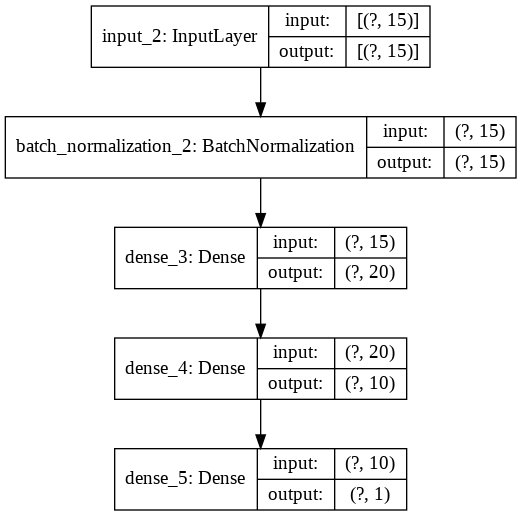

In [85]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Visualize the structure

#### Compile

In [86]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'Recall', 'Precision'],
    )

#### Make an EarlyStopping callback

In [87]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

#### Fit the model

In [88]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size = 16,
                    epochs=50,
                    callbacks=[callback],
                    verbose=0)

#### Plot model performance on the validation data (accuracy, recall, and precision)

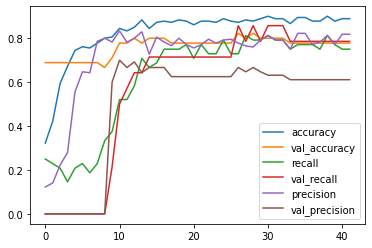

In [89]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.legend()

#### Save model

In [90]:
model.save('heart_1')

INFO:tensorflow:Assets written to: heart_1/assets


In [91]:
!pwd

/content


#### Load model

In [92]:
reloaded = tf.keras.models.load_model('heart_1')

In [93]:
reloaded.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 601
Trainable params: 571
Non-trainable params: 30
_________________________________________________________________


#### Evaluate on test set 

In [94]:
reloaded.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.8553 - recall_1: 0.7619 - precision_1: 0.7273


[0.31172922253608704,
 0.8552631735801697,
 0.761904776096344,
 0.7272727489471436]

#### X_test predictions

In [95]:
preds = reloaded.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


#### What do those look like?

#### How is the model performing? 
Let's look at the confusion matrix using TF.

Or just use sklearn's confusion matrix. 

In [96]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, balanced_accuracy_score

In [97]:
confusion_matrix(y_test, preds)

array([[49,  6],
       [ 5, 16]])

#### Evaluate with other metrics

In [98]:
recall_score(y_test, preds)

0.7619047619047619

In [99]:
f1_score(y_test, preds)

0.7441860465116279

In [100]:
balanced_accuracy_score(y_test, preds)

0.8264069264069264

### Make a null model

In [102]:
y_test.value_counts(normalize=True)

0    0.723684
1    0.276316
Name: target, dtype: float64

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

In [103]:
# lab time lab time lab time !!!!!!!

#### Save your best model. 


#### Compare with other algorithms
Compare your best neural net model to a scikit-learn LogisticRegression model. Also try a GradientBoostingClassifier.

#### Scale and Standardize for Logistic Regression


#### Logistic Regression

#### Evaluate performance on metrics other than accuracy

### GradientBoosting

#### Evaluate performance on metrics other than accuracy

#### Which evaluation metric(s) are best to use in this problem?

#### Which model would you recommend for use? Why?


#### Download your notebook and put it in your submission folder. 🎉